In [1]:
import numpy as np
import tensorflow as tf
import tqdm
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline

mnist = input_data.read_data_sets('../MNIST/', one_hot=True)

Extracting ../MNIST/train-images-idx3-ubyte.gz
Extracting ../MNIST/train-labels-idx1-ubyte.gz
Extracting ../MNIST/t10k-images-idx3-ubyte.gz
Extracting ../MNIST/t10k-labels-idx1-ubyte.gz


In [2]:
# Generate predetermined random weights so the networks are similarly initialized
w1_initial = np.random.normal(size=(784, 100)).astype(np.float32)
w2_initial = np.random.normal(size=(100, 100)).astype(np.float32)
w3_initial = np.random.normal(size=(100, 10)).astype(np.float32)

# Small epsilon value for the BN transform
epsilon = 1e-3

In [3]:
# Placeholders
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [4]:
# Layer 1 without BN
w1 = tf.Variable(w1_initial)
b1 = tf.Variable(tf.zeros([100]))
z1 = tf.matmul(x,w1)+b1
l1 = tf.nn.sigmoid(z1)

In [22]:
# Layer 1 with BN
w1_BN = tf.Variable(w1_initial)

# Note that pre-batch normalization bias is ommitted. The effect of this bias would be
# eliminated when subtracting the batch mean. Instead, the role of the bias is performed
# by the new beta variable. See Section 3.2 of the BN2015 paper.
z1_BN = tf.matmul(x,w1_BN)

# Calculate batch mean and variance
batch_mean1, batch_var1 = tf.nn.moments(z1_BN,[0])

# Apply the initial batch normalizing transform
z1_hat = (z1_BN - batch_mean1) / tf.sqrt(batch_var1 + epsilon)

# Create two new parameters, scale and beta (shift)
scale1 = tf.Variable(tf.ones([100]))
beta1 = tf.Variable(tf.zeros([100]))

# Scale and shift to obtain the final output of the batch normalization
# this value is fed into the activation function (here a sigmoid)
BN1 = scale1 * z1_hat + beta1
l1_BN = tf.nn.sigmoid(BN1)

In [ ]:
print(z1_BN)
print(batch_mean1)
print(batch_var1)
print(BN1) 
print(l1_BN)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
batch = mnist.train.next_batch(2)
sess.run([z1_BN, batch_mean1, batch_var1], feed_dict={x: batch[0]})

In [6]:
# Layer 2 without BN
w2 = tf.Variable(w2_initial)
b2 = tf.Variable(tf.zeros([100]))
z2 = tf.matmul(l1,w2)+b2
l2 = tf.nn.sigmoid(z2)

In [7]:
# Layer 2 with BN, using Tensorflows built-in BN function
w2_BN = tf.Variable(w2_initial)
z2_BN = tf.matmul(l1_BN,w2_BN)
batch_mean2, batch_var2 = tf.nn.moments(z2_BN,[0])
scale2 = tf.Variable(tf.ones([100]))
beta2 = tf.Variable(tf.zeros([100]))
BN2 = tf.nn.batch_normalization(z2_BN,batch_mean2,batch_var2,beta2,scale2,epsilon)
l2_BN = tf.nn.sigmoid(BN2)

In [8]:
# Softmax
w3 = tf.Variable(w3_initial)
b3 = tf.Variable(tf.zeros([10]))
y  = tf.nn.softmax(tf.matmul(l2,w3)+b3)

w3_BN = tf.Variable(w3_initial)
b3_BN = tf.Variable(tf.zeros([10]))
y_BN  = tf.nn.softmax(tf.matmul(l2_BN,w3_BN)+b3_BN)

In [10]:
# Loss, optimizer and predictions
cross_entropy = -tf.reduce_sum(y_*tf.log(y))
cross_entropy_BN = -tf.reduce_sum(y_*tf.log(y_BN))

train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
train_step_BN = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy_BN)

correct_prediction = tf.equal(tf.arg_max(y,1),tf.arg_max(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
correct_prediction_BN = tf.equal(tf.arg_max(y_BN,1),tf.arg_max(y_,1))
accuracy_BN = tf.reduce_mean(tf.cast(correct_prediction_BN,tf.float32))

In [11]:
zs, BNs, acc, acc_BN = [], [], [], []

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for i in tqdm.tqdm(range(40000)):
    batch = mnist.train.next_batch(60)
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})
    train_step_BN.run(feed_dict={x: batch[0], y_: batch[1]})
    if i % 50 is 0:
        res = sess.run([accuracy,accuracy_BN,z2,BN2],feed_dict={x: mnist.test.images, y_: mnist.test.labels})
        acc.append(res[0])
        acc_BN.append(res[1])
        zs.append(np.mean(res[2],axis=0)) # record the mean value of z2 over the entire test set
        BNs.append(np.mean(res[3],axis=0)) # record the mean value of BN2 over the entire test set

zs, BNs, acc, acc_BN = np.array(zs), np.array(BNs), np.array(acc), np.array(acc_BN)

100%|███████████████████████████████████████████████████████████████████████████████| 40000/40000 [02:42<00:00, 267.42it/s]


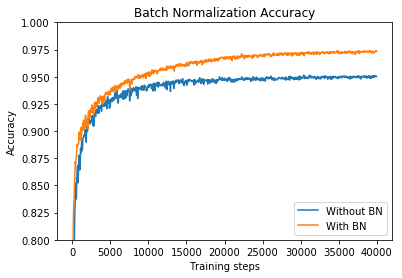

In [12]:
fig, ax = plt.subplots()

ax.plot(range(0,len(acc)*50,50),acc, label='Without BN')
ax.plot(range(0,len(acc)*50,50),acc_BN, label='With BN')
ax.set_xlabel('Training steps')
ax.set_ylabel('Accuracy')
ax.set_ylim([0.8,1])
ax.set_title('Batch Normalization Accuracy')
ax.legend(loc=4)
plt.show()

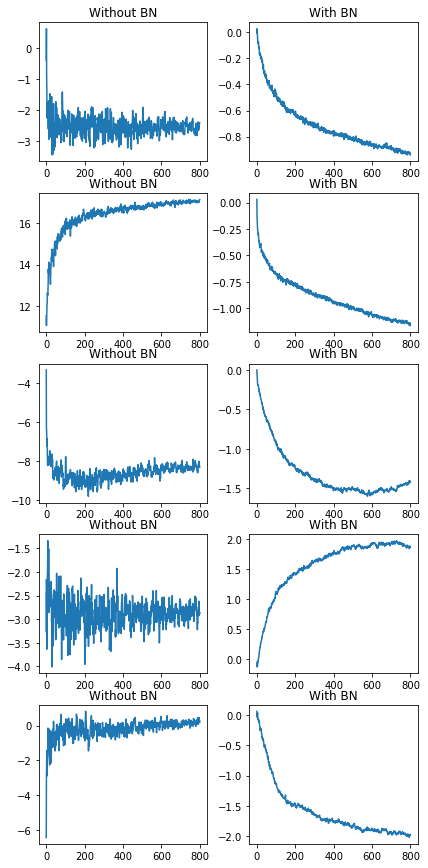

In [26]:
fig, axes = plt.subplots(5, 2, figsize=(6,12))
fig.tight_layout()

for i, ax in enumerate(axes):
    ax[0].set_title("Without BN")
    ax[1].set_title("With BN")
    ax[0].plot(zs[:,i])
    ax[1].plot(BNs[:,i])

In [27]:
predictions = []
correct = 0
for i in range(100):
    pred, corr = sess.run([tf.arg_max(y_BN,1), accuracy_BN],
                         feed_dict={x: [mnist.test.images[i]], y_: [mnist.test.labels[i]]})
    correct += corr
    predictions.append(pred[0])
print("PREDICTIONS:", predictions)
print("ACCURACY:", correct/100)

PREDICTIONS: [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
ACCURACY: 0.15
